In [1]:
print('Connect to google drive')
from google.colab import drive
drive.mount('/gdrive')

Connect to google drive
Mounted at /gdrive


In [2]:
print('Import necessary libraries')

import numpy as np
import pandas as pd
import scipy.stats as stats
from pathlib import Path
import glob
import pickle

import warnings
warnings.filterwarnings("ignore")

import random
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import gc
import tqdm

from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder

import joblib
import lightgbm as lgb


Import necessary libraries


In [3]:
base_path='/gdrive/My Drive/Colab Notebooks/'
weights_path='/gdrive/My Drive/Colab Notebooks/weights/'

In [4]:
def euclidean_distance(x_true,y_true, x_pred, y_pred):
    return np.mean(((x_true-x_pred)**2+(y_true-y_pred)**2)**0.5)    

In [5]:
version='forPdata423_numPaths'


In [6]:
data=pd.read_csv('/gdrive/My Drive/Colab Notebooks/data423.csv.zip') #
data.shape

(14373, 316)

In [7]:
rssidsnums=[int(x[4:]) for x in data.columns if 'rsid' in x]
print(len(rssidsnums))

312


In [8]:
data.head()

,rsid1,rsid2,rsid3,rsid4,rsid5,rsid6,rsid7,rsid8,rsid9,rsid10,rsid11,rsid12,rsid13,rsid14,rsid15,rsid16,rsid17,rsid18,rsid19,rsid20,rsid21,rsid22,rsid23,rsid24,rsid25,rsid26,rsid27,rsid28,rsid29,rsid30,rsid31,rsid32,rsid33,rsid34,rsid35,rsid36,rsid37,rsid38,rsid39,rsid40,...,rsid277,rsid278,rsid279,rsid280,rsid281,rsid282,rsid283,rsid284,rsid285,rsid286,rsid287,rsid288,rsid289,rsid290,rsid291,rsid292,rsid293,rsid294,rsid295,rsid296,rsid297,rsid298,rsid299,rsid300,rsid301,rsid302,rsid303,rsid304,rsid305,rsid306,rsid307,rsid308,rsid309,rsid310,rsid311,rsid312,x,y,timestamp,path
0,-93,-999,-81,-999,-999,-999,-999,-999,-999,-999,-999,-85,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-48,-48,-49,-44,-43,-43,-999,-999,-999,-999,-999,-999,...,-81,-80,-999,-999,-999,-87,-999,-999,-78,-79,-78,-79,-79,-78,-999,-999,-999,-999,-999,-999,-999,-81,-82,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,43.26,25.89,1633934464983,record_2021_10_11_07_41_02
1,-93,-999,-81,-999,-999,-999,-999,-999,-999,-999,-999,-85,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-48,-48,-49,-44,-43,-43,-999,-999,-999,-999,-999,-999,...,-81,-80,-999,-999,-999,-87,-999,-999,-78,-79,-78,-79,-79,-78,-999,-999,-999,-999,-999,-999,-999,-81,-82,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,43.26,25.89,1633934467125,record_2021_10_11_07_41_02
2,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-84,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-56,-999,-999,-39,-43,-42,-999,-999,-999,-999,-999,-999,...,-82,-82,-84,-85,-81,-87,-999,-999,-999,-999,-85,-999,-88,-999,-999,-999,-999,-999,-999,-999,-999,-85,-86,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,43.26,25.89,1633934469251,record_2021_10_11_07_41_02
3,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-84,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-56,-999,-999,-39,-43,-42,-999,-999,-999,-999,-999,-999,...,-82,-82,-84,-85,-81,-87,-999,-999,-999,-999,-85,-999,-88,-999,-999,-999,-999,-999,-999,-999,-999,-85,-86,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,43.26,25.89,1633934471370,record_2021_10_11_07_41_02
4,-78,-999,-999,-95,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-50,-51,-51,-43,-49,-47,-999,-999,-999,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-87,-87,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,40.85,25.74,1633934473508,record_2021_10_11_07_41_02


In [9]:
TRAIN_FEATS=[x for x in data.columns if x not in ['x', 'y', 'path', 'timestamp']]
len(TRAIN_FEATS)

312

In [10]:
dataA=data.copy()

In [11]:
unpaths=data.path.unique()

In [12]:
print('we have ',len(unpaths),' unique paths')

we have  423  unique paths


### CV TRAIN

In [13]:
hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l1','l2'],
    'learning_rate': 0.005,
    'feature_fraction': 0.2,
    'bagging_fraction': 0.8,
    'bagging_freq': 10,
    'verbose': 0,
    "max_depth": 11,
    "num_leaves": 256,  
    "max_bin": 256,
    "num_iterations": 15000
}
# hyper_params = {
#     'task': 'train',
#     'boosting_type': 'gbdt',
#     'objective': 'regression',
#     'metric': ['l1','l2'],
#     'learning_rate': 0.005,
#     'feature_fraction': 0.2,
#     'bagging_fraction': 0.8,
#     'bagging_freq': 10,
#     'verbose': 0,
#     "max_depth": 14,
#     "num_leaves": 256,  
#     "max_bin": 256,
#     "num_iterations": 15000
# }


In [14]:
# CROSS VALIDATION

name='lgbm'+version


scores=[]
for rs in range(40):
    unpaths=dataA.path.unique()
    np.random.seed(2022+rs)
    unpaths=np.random.choice(unpaths,size=317,replace=False)
    data=dataA.loc[dataA.path.isin(unpaths),:]

    score_df = pd.DataFrame()
    oof = list()
    predictions = list()

    oof_x, oof_y = np.zeros(data.shape[0]), np.zeros(data.shape[0])
    preds_x, preds_y = 0, 0

    scores_per_fold=[]

    all_preds=[]
    all_targets=[]

    np.random.seed(42)
    sh=np.random.permutation(unpaths)


    k=5
    val_size=int(len(sh)/k)
    for f in range(k):
        # print('fold:', f)

        if f<(k-1):
            val_paths=sh[val_size*f:val_size*(f+1)]
        else:
            val_paths=sh[val_size*f:]

        train_paths=[x for x in unpaths if x not in val_paths]
        
        val_paths=np.array(val_paths)
        train_paths=np.array(train_paths)
        
        X_train = data.loc[data.path.isin(train_paths), TRAIN_FEATS ].reset_index(drop=True)

        y_trainXY =  data.loc[data.path.isin(train_paths), ['x', 'y'] ].reset_index(drop=True).values

        X_val = data.loc[data.path.isin(val_paths), TRAIN_FEATS ].reset_index(drop=True)
        y_valXY = data.loc[data.path.isin(val_paths), ['x', 'y'] ].reset_index(drop=True).values

        val_predsXY=[]
        for i in range(2):
            y_train = y_trainXY[:,i]
            y_val = y_valXY[:,i]

            gbm = lgb.LGBMRegressor(**hyper_params)
            model = gbm.fit(X_train, y_train,
                eval_set=[(X_train, y_train), (X_val, y_val)],
                eval_metric='l1',
                verbose=1000,
                # verbose=100,
                early_stopping_rounds=200)
            
            joblib.dump(model, weights_path+'fold_'+str(f)+['x','y'][i]+'_v2')
            
            val_predsXY.append(gbm.predict(X_val, num_iteration=gbm.best_iteration_) )
        val_predsXY=np.stack(val_predsXY).T
        
        # print(euclidean_distance(val_predsXY[:,0], val_predsXY[:,1], y_valXY[:,0], y_valXY[:,1]))

        all_preds.append(val_predsXY)
        all_targets.append(y_valXY)
            

    all_predsV=np.vstack(all_preds)
    all_targetsV=np.vstack(all_targets)    
    print(rs,'mean validation error, 5-fold', euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))
    scores.append(euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))
    print(np.mean(scores))
    print('---------------------')

Training until validation scores don't improve for 200 rounds.
[1000]	training's l2: 1.4761	training's l1: 0.8484	valid_1's l2: 3.39699	valid_1's l1: 1.36963
[2000]	training's l2: 1.18948	training's l1: 0.760085	valid_1's l2: 3.34703	valid_1's l1: 1.35048
[3000]	training's l2: 1.03995	training's l1: 0.710362	valid_1's l2: 3.33666	valid_1's l1: 1.34744
Early stopping, best iteration is:
[3212]	training's l2: 1.01654	training's l1: 0.701476	valid_1's l2: 3.33535	valid_1's l1: 1.34652
Training until validation scores don't improve for 200 rounds.
[1000]	training's l2: 0.79547	training's l1: 0.56928	valid_1's l2: 2.90115	valid_1's l1: 1.06545
[2000]	training's l2: 0.629714	training's l1: 0.486392	valid_1's l2: 2.87366	valid_1's l1: 1.04987
Early stopping, best iteration is:
[2547]	training's l2: 0.587762	training's l1: 0.463652	valid_1's l2: 2.86714	valid_1's l1: 1.04787
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[737]	training's l2: 1

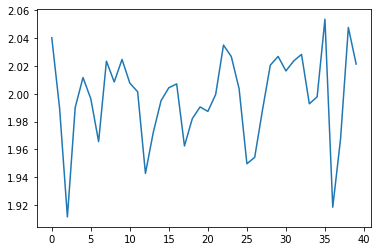

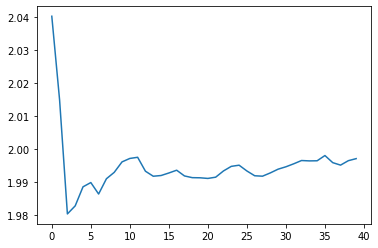

1.9971570051538805
0.03204490326503892


In [18]:
import matplotlib.pyplot as plt
plt.plot(scores)
plt.show()

plt.plot(np.cumsum(scores)/np.arange(1,len(scores)+1))
plt.show()

print(np.mean(scores))
print(np.std(scores))

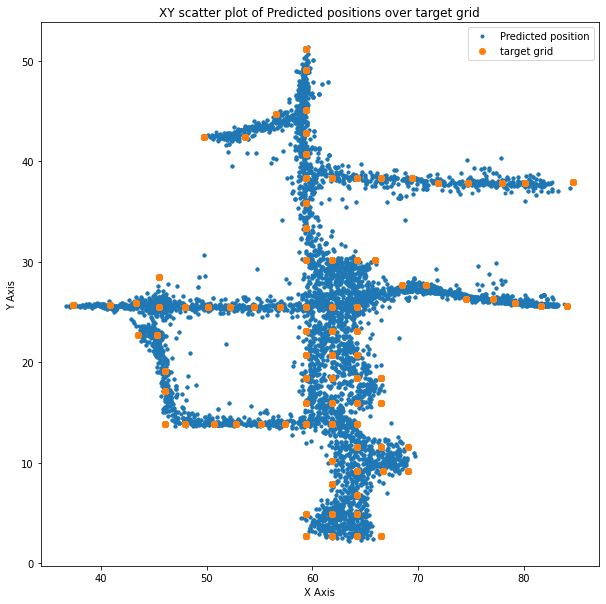

mean validation error, 5-fold 2.0213573402348928


In [19]:
plt.figure(figsize=(10,10))
plt.title('XY scatter plot of Predicted positions over target grid')
plt.plot(all_predsV[:,0],all_predsV[:,1],'.', label='Predicted position')
plt.plot(all_targetsV[:,0],all_targetsV[:,1],'o', label='target grid')
plt.legend()
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.show()
print('mean validation error, 5-fold', euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))

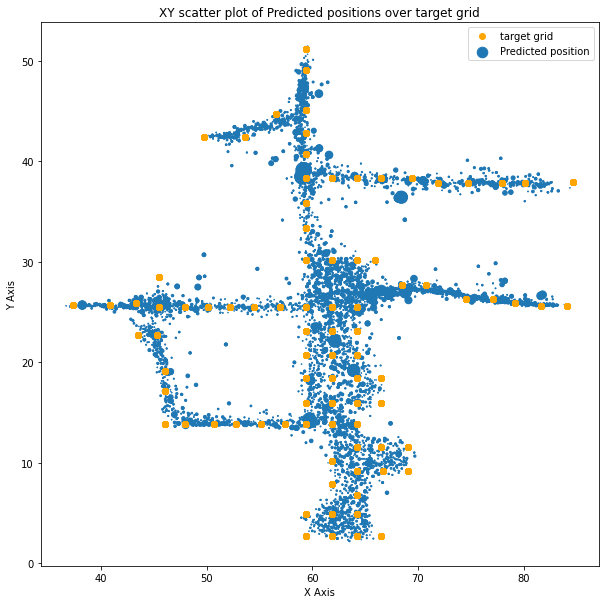

mean validation error, 5-fold 2.0213573402348928


In [20]:
scoreperrow=[]
for row in range(len(all_targetsV)):
    scoreperrow.append(euclidean_distance(all_targetsV[row,0], all_targetsV[row,1], all_predsV[row,0], all_predsV[row,1]))
    
plt.figure(figsize=(10,10))
plt.title('XY scatter plot of Predicted positions over target grid')
plt.plot(all_targetsV[:,0],all_targetsV[:,1],'o', color="orange", label='target grid')
plt.scatter(all_predsV[:,0],all_predsV[:,1],s=0.5*np.array(scoreperrow)**2, label='Predicted position')
plt.legend()
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.show()
print('mean validation error, 5-fold', euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))

In [21]:
# CROSS VALIDATION

name='lgbm'+version


scores=[]
for rs in range(40):
    unpaths=dataA.path.unique()
    np.random.seed(2022+rs)
    unpaths=np.random.choice(unpaths,size=211,replace=False)
    data=dataA.loc[dataA.path.isin(unpaths),:]

    score_df = pd.DataFrame()
    oof = list()
    predictions = list()

    oof_x, oof_y = np.zeros(data.shape[0]), np.zeros(data.shape[0])
    preds_x, preds_y = 0, 0

    scores_per_fold=[]

    all_preds=[]
    all_targets=[]

    np.random.seed(42)
    sh=np.random.permutation(unpaths)


    k=5
    val_size=int(len(sh)/k)
    for f in range(k):
        # print('fold:', f)

        if f<(k-1):
            val_paths=sh[val_size*f:val_size*(f+1)]
        else:
            val_paths=sh[val_size*f:]

        train_paths=[x for x in unpaths if x not in val_paths]
        
        val_paths=np.array(val_paths)
        train_paths=np.array(train_paths)
        
        X_train = data.loc[data.path.isin(train_paths), TRAIN_FEATS ].reset_index(drop=True)

        y_trainXY =  data.loc[data.path.isin(train_paths), ['x', 'y'] ].reset_index(drop=True).values

        X_val = data.loc[data.path.isin(val_paths), TRAIN_FEATS ].reset_index(drop=True)
        y_valXY = data.loc[data.path.isin(val_paths), ['x', 'y'] ].reset_index(drop=True).values

        val_predsXY=[]
        for i in range(2):
            y_train = y_trainXY[:,i]
            y_val = y_valXY[:,i]

            gbm = lgb.LGBMRegressor(**hyper_params)
            model = gbm.fit(X_train, y_train,
                eval_set=[(X_train, y_train), (X_val, y_val)],
                eval_metric='l1',
                verbose=1000,
                # verbose=100,
                early_stopping_rounds=200)
            
            joblib.dump(model, weights_path+'fold_'+str(f)+['x','y'][i]+'_v2')
            
            val_predsXY.append(gbm.predict(X_val, num_iteration=gbm.best_iteration_) )
        val_predsXY=np.stack(val_predsXY).T
        
        # print(euclidean_distance(val_predsXY[:,0], val_predsXY[:,1], y_valXY[:,0], y_valXY[:,1]))

        all_preds.append(val_predsXY)
        all_targets.append(y_valXY)
            

    all_predsV=np.vstack(all_preds)
    all_targetsV=np.vstack(all_targets)    
    print(rs,'mean validation error, 5-fold', euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))
    scores.append(euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))
    print(np.mean(scores))
    print('---------------------')

Training until validation scores don't improve for 200 rounds.
[1000]	training's l2: 1.27365	training's l1: 0.808106	valid_1's l2: 4.11436	valid_1's l1: 1.49846
Early stopping, best iteration is:
[1245]	training's l2: 1.15202	training's l1: 0.763943	valid_1's l2: 4.07388	valid_1's l1: 1.48908
Training until validation scores don't improve for 200 rounds.
[1000]	training's l2: 0.732718	training's l1: 0.55522	valid_1's l2: 2.67503	valid_1's l1: 1.0764
Early stopping, best iteration is:
[1035]	training's l2: 0.718222	training's l1: 0.5475	valid_1's l2: 2.67114	valid_1's l1: 1.07598
Training until validation scores don't improve for 200 rounds.
[1000]	training's l2: 1.18822	training's l1: 0.77909	valid_1's l2: 5.08225	valid_1's l1: 1.60077
[2000]	training's l2: 0.894463	training's l1: 0.669263	valid_1's l2: 4.89753	valid_1's l1: 1.57437
[3000]	training's l2: 0.752748	training's l1: 0.605735	valid_1's l2: 4.83309	valid_1's l1: 1.56902
Early stopping, best iteration is:
[3290]	training's l2:

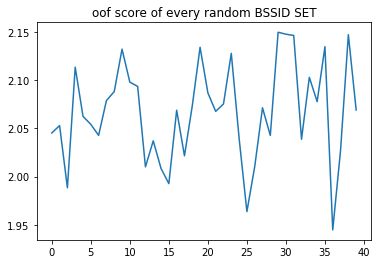

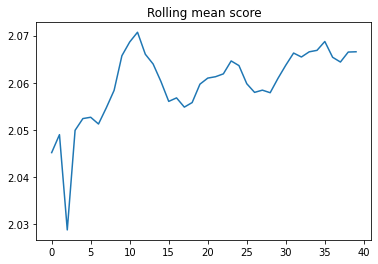

40
2.0665663928591513
0.05112216276150306


In [22]:
import matplotlib.pyplot as plt
plt.plot(scores)
plt.title('oof score of every random BSSID SET')
plt.show()

plt.plot(np.cumsum(scores)/np.arange(1,len(scores)+1))
plt.title('Rolling mean score')
plt.show()

print(len(scores))
print(np.mean(scores))
print(np.std(scores))

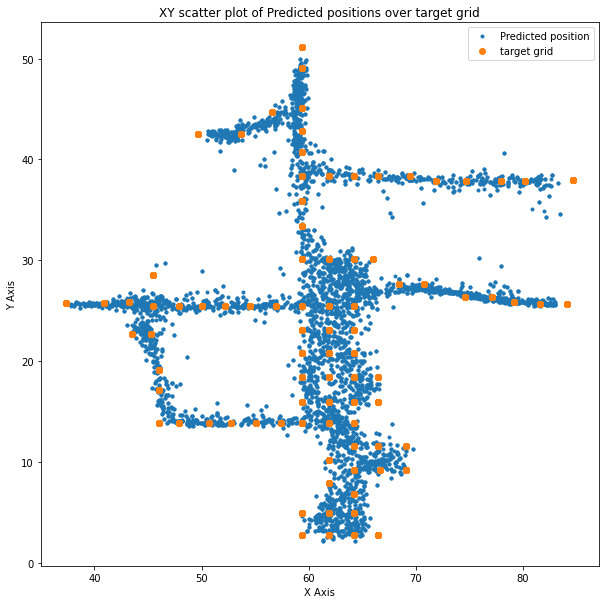

mean validation error, 5-fold 2.0689496641848604


In [23]:
plt.figure(figsize=(10,10))
plt.title('XY scatter plot of Predicted positions over target grid')
plt.plot(all_predsV[:,0],all_predsV[:,1],'.', label='Predicted position')
plt.plot(all_targetsV[:,0],all_targetsV[:,1],'o', label='target grid')
plt.legend()
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.show()
print('mean validation error, 5-fold', euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))

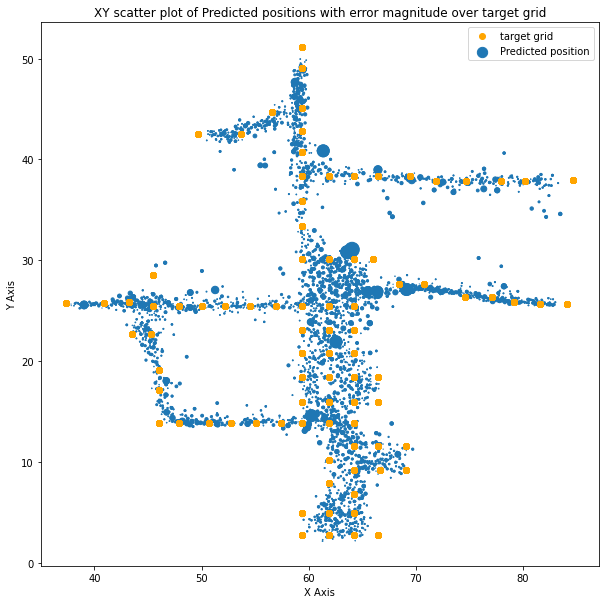

mean validation error, 5-fold 2.0689496641848604


In [24]:
scoreperrow=[]
for row in range(len(all_targetsV)):
    scoreperrow.append(euclidean_distance(all_targetsV[row,0], all_targetsV[row,1], all_predsV[row,0], all_predsV[row,1]))
    
plt.figure(figsize=(10,10))
plt.title('XY scatter plot of Predicted positions with error magnitude over target grid')
plt.plot(all_targetsV[:,0],all_targetsV[:,1],'o', color="orange", label='target grid')
plt.scatter(all_predsV[:,0],all_predsV[:,1],s=0.5*np.array(scoreperrow)**2, label='Predicted position')
plt.legend()
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.show()
print('mean validation error, 5-fold', euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))

In [25]:
# CROSS VALIDATION

name='lgbm'+version


scores=[]
for rs in range(40):
    unpaths=dataA.path.unique()
    np.random.seed(2022+rs)
    unpaths=np.random.choice(unpaths,size=106,replace=False)
    data=dataA.loc[dataA.path.isin(unpaths),:]

    score_df = pd.DataFrame()
    oof = list()
    predictions = list()

    oof_x, oof_y = np.zeros(data.shape[0]), np.zeros(data.shape[0])
    preds_x, preds_y = 0, 0

    scores_per_fold=[]

    all_preds=[]
    all_targets=[]

    np.random.seed(42)
    sh=np.random.permutation(unpaths)


    k=5
    val_size=int(len(sh)/k)
    for f in range(k):
        # print('fold:', f)

        if f<(k-1):
            val_paths=sh[val_size*f:val_size*(f+1)]
        else:
            val_paths=sh[val_size*f:]

        train_paths=[x for x in unpaths if x not in val_paths]
        
        val_paths=np.array(val_paths)
        train_paths=np.array(train_paths)
        
        X_train = data.loc[data.path.isin(train_paths), TRAIN_FEATS ].reset_index(drop=True)

        y_trainXY =  data.loc[data.path.isin(train_paths), ['x', 'y'] ].reset_index(drop=True).values

        X_val = data.loc[data.path.isin(val_paths), TRAIN_FEATS ].reset_index(drop=True)
        y_valXY = data.loc[data.path.isin(val_paths), ['x', 'y'] ].reset_index(drop=True).values

        val_predsXY=[]
        for i in range(2):
            y_train = y_trainXY[:,i]
            y_val = y_valXY[:,i]

            gbm = lgb.LGBMRegressor(**hyper_params)
            model = gbm.fit(X_train, y_train,
                eval_set=[(X_train, y_train), (X_val, y_val)],
                eval_metric='l1',
                verbose=1000,
                # verbose=100,
                early_stopping_rounds=200)
            
            joblib.dump(model, weights_path+'fold_'+str(f)+['x','y'][i]+'_v2')
            
            val_predsXY.append(gbm.predict(X_val, num_iteration=gbm.best_iteration_) )
        val_predsXY=np.stack(val_predsXY).T
        
        # print(euclidean_distance(val_predsXY[:,0], val_predsXY[:,1], y_valXY[:,0], y_valXY[:,1]))

        all_preds.append(val_predsXY)
        all_targets.append(y_valXY)
            

    all_predsV=np.vstack(all_preds)
    all_targetsV=np.vstack(all_targets)    
    print(rs,'mean validation error, 5-fold', euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))
    scores.append(euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))
    print(np.mean(scores))
    print('---------------------')

Training until validation scores don't improve for 200 rounds.
[1000]	training's l2: 1.33304	training's l1: 0.8005	valid_1's l2: 4.56037	valid_1's l1: 1.56102
Early stopping, best iteration is:
[1270]	training's l2: 1.18424	training's l1: 0.753001	valid_1's l2: 4.52518	valid_1's l1: 1.55451
Training until validation scores don't improve for 200 rounds.
[1000]	training's l2: 0.783215	training's l1: 0.569853	valid_1's l2: 2.64523	valid_1's l1: 1.18448
Early stopping, best iteration is:
[1792]	training's l2: 0.586827	training's l1: 0.485051	valid_1's l2: 2.59737	valid_1's l1: 1.16594
Training until validation scores don't improve for 200 rounds.
[1000]	training's l2: 1.28628	training's l1: 0.797072	valid_1's l2: 4.89604	valid_1's l1: 1.52694
Early stopping, best iteration is:
[1099]	training's l2: 1.22907	training's l1: 0.778428	valid_1's l2: 4.88978	valid_1's l1: 1.52343
Training until validation scores don't improve for 200 rounds.
[1000]	training's l2: 0.743765	training's l1: 0.554773	

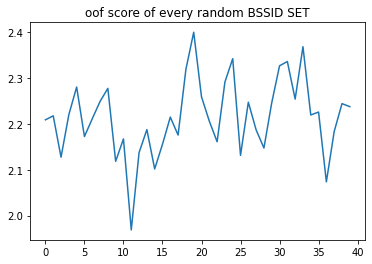

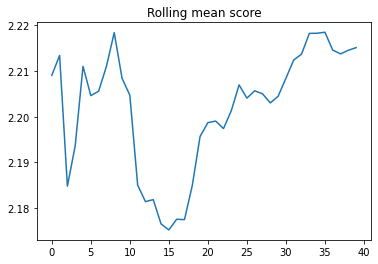

40
2.21515196863025
0.08327492295391108


In [26]:
import matplotlib.pyplot as plt
plt.plot(scores)
plt.title('oof score of every random BSSID SET')
plt.show()

plt.plot(np.cumsum(scores)/np.arange(1,len(scores)+1))
plt.title('Rolling mean score')
plt.show()

print(len(scores))
print(np.mean(scores))
print(np.std(scores))

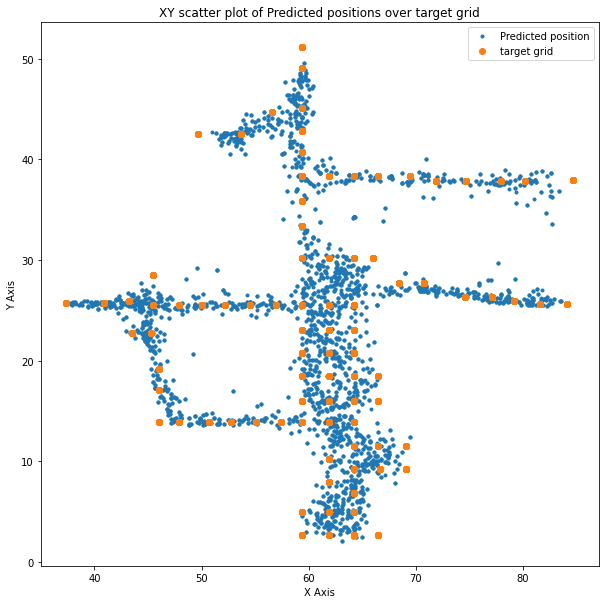

mean validation error, 5-fold 2.237902994086595


In [27]:
plt.figure(figsize=(10,10))
plt.title('XY scatter plot of Predicted positions over target grid')
plt.plot(all_predsV[:,0],all_predsV[:,1],'.', label='Predicted position')
plt.plot(all_targetsV[:,0],all_targetsV[:,1],'o', label='target grid')
plt.legend()
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.show()
print('mean validation error, 5-fold', euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))

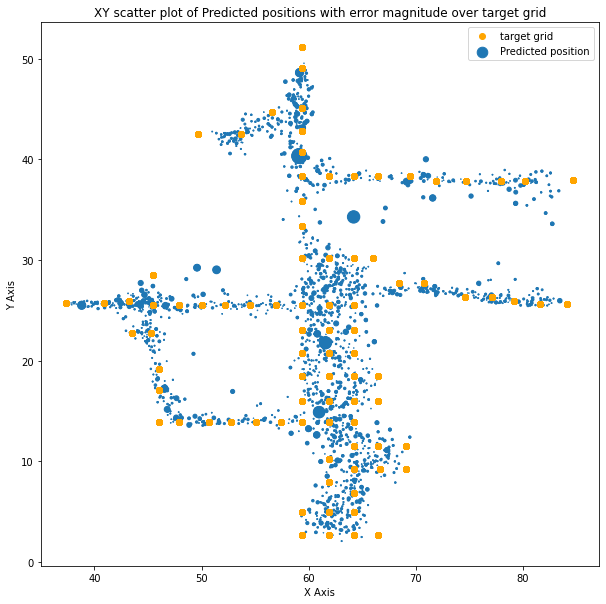

mean validation error, 5-fold 2.237902994086595


In [28]:
scoreperrow=[]
for row in range(len(all_targetsV)):
    scoreperrow.append(euclidean_distance(all_targetsV[row,0], all_targetsV[row,1], all_predsV[row,0], all_predsV[row,1]))
    
plt.figure(figsize=(10,10))
plt.title('XY scatter plot of Predicted positions with error magnitude over target grid')
plt.plot(all_targetsV[:,0],all_targetsV[:,1],'o', color="orange", label='target grid')
plt.scatter(all_predsV[:,0],all_predsV[:,1],s=0.5*np.array(scoreperrow)**2, label='Predicted position')
plt.legend()
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.show()
print('mean validation error, 5-fold', euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))

In [ ]:
# pd.DataFrame(all_predsV,columns=['x', 'y']).to_csv('/gdrive/My Drive/Colab Notebooks/'+name+'_oof2.csv.gz', index=False, compression='gzip')
# pd.DataFrame(all_targetsV,columns=['x', 'y']).to_csv('/gdrive/My Drive/Colab Notebooks/all_targetsV2.csv.gz', index=False, compression='gzip')

In [ ]:
# '/gdrive/My Drive/Colab Notebooks/'+name+'_oof.csv.gz'

In [ ]:
version

## Full train

In [ ]:
# hyper_params["num_iterations"]= 2500

In [ ]:


# name=version+'lgbm'

# train_paths=unpaths[:]

# train_paths=np.array(train_paths)

# X_train = data.loc[data.path.isin(train_paths), TRAIN_FEATS ].reset_index(drop=True)

# y_trainXY =  data.loc[data.path.isin(train_paths), ['x', 'y'] ].reset_index(drop=True).values

# train_predsXY=[]
# all_train_targets=[]
# xy=['x', 'y']
# for i in range(2):
#     y_train = y_trainXY[:,i]

#     gbm = lgb.LGBMRegressor(**hyper_params)


#     model = gbm.fit(X_train, y_train,
#         eval_set=[(X_train, y_train)],
#         eval_metric='l1',
#         verbose=100
#         )
    
#     # joblib.dump(model, weights_path+'FullTrain_'+['x','y'][i])
#     joblib.dump(model,'/gdrive/My Drive/Colab Notebooks/weights/'+name+'_model'+xy[i])

#     train_predsXY.append(gbm.predict(X_train, num_iteration=gbm.best_iteration_) )

# train_predsXY=np.stack(train_predsXY).T

# print('train error',euclidean_distance(train_predsXY[:,0], train_predsXY[:,1], y_trainXY[:,0], y_trainXY[:,1]))


In [ ]:
# print('Save LightGBM model fully trained')
# joblib.dump(model,'/gdrive/My Drive/Colab Notebooks/weights/'+name+'_model')